In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

import mtg

In [5]:
past_games = mtg.PastGames()

/home/mson/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/mson/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: l2_lambda
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[1]	training's binary_logloss: 0.691097	valid_1's binary_logloss: 0.691235
[2]	training's binary_logloss: 0.689273	valid_1's binary_logloss: 0.689503
[3]	training's binary_logloss: 0.687696	valid_1's binary_logloss: 0.688013
[4]	training's binary_logloss: 0.686175	valid_1's binary_logloss: 0.686673
[5]	training's binary_logloss: 0.684675	valid_1's binary_logloss: 0.685275
[6]	training's binary_logloss: 0.683351	valid_1's binary_logloss: 0.68405
[7]	training's binary_logloss: 0.682206	valid_1's binary_logloss: 0.682897
[8]	training's binary_logloss: 0.680851	valid_1's binary_logloss: 0.681671
[9]	training's binary_logloss: 0.67991	valid_1's binary_logloss: 0.680744
[10]	training's binary_logloss: 0.678769	valid_1's binary_logloss: 0.679725
[11]	training's binary_logloss: 0.67765	valid_1's binary_logloss: 0.678641
[12]

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

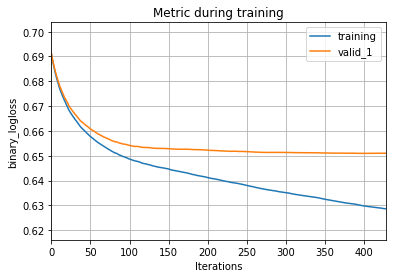

In [6]:
lgb_params = {'objective': 'binary', 'num_leaves': 32, 'l2_lambda': 0.3, 'max_depth': -1}

model = lgb.LGBMClassifier(**lgb_params, num_boost_round=1000)
trn, val = past_games.dsets.sets['trn'], past_games.dsets.sets['val']
model.fit(**past_games.dsets.sets['trn'], eval_set=[(trn['X'], trn['y']), (val['X'], val['y'])],
          early_stopping_rounds=30)

lgb.plot_metric(model)

In [7]:

pred = model.predict(past_games.dsets.sets['tst']['X'])
roc_auc_score(y_true=past_games.dsets.sets['tst']['y'], y_score=pred)

0.6147214295249602

In [17]:
rival_deck = mtg.RivalDeck(past_games)

In [18]:
rival_deck.deck

,Alessin_Adamant_Angel,Bold_Battalion,Dreadwing_Darkfire_Dragon,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End,Gentle_Guard,Horrible_Hooligan,Kindly_Knight,Lilac_Lotus,Murderous_Minotaur,Patchy_Pirate,Sword_of_Shadows,Virtuous_Vigilante
0,1,1,1,1,1,1,1,1,1,1,1,1


In [13]:
past_games.cards

['Alessin_Adamant_Angel',
 'Bold_Battalion',
 'Dreadwing_Darkfire_Dragon',
 'Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End',
 'Gentle_Guard',
 'Horrible_Hooligan',
 'Kindly_Knight',
 'Lilac_Lotus',
 'Murderous_Minotaur',
 'Patchy_Pirate',
 'Sword_of_Shadows',
 'Virtuous_Vigilante']

In [23]:

from itertools import combinations
list(combinations([1, 2, 3], 3))

[(1, 2, 3)]